In [2]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
import math
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14
from sklearn.utils import check_random_state
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from utils import load_banking, load_reduced_banking

import warnings
warnings.filterwarnings('ignore')
rand_state=123;


In [24]:
# A random forest classifier will be composed as a combination of N decision tree classifiers. 
# In each classifier the two variable parameters used for growing a tree will be the maximum depth
# and the number of features considered 
def generate_DTCs(n_trees=20, rand=True, n_features=10, max_depth=7):
    estimators = []
    for n in range(0,n_trees):
        if rand :
            max_d = np.random.randint(1, max_depth)
            max_f = np.random.randint(1, n_features+1)
        else :
            max_d = max_depth
            max_f = n_features
        clf = DecisionTreeClassifier(max_depth=max_d, max_features=max_f, random_state=rand_state)
        estimators.append(("{}-{:03}".format('clf', n),clf))
    return estimators    

def plot_test_results(estimators, ensemble, X_test, y_test):
    accuracy = []
    curr_features = []
    max_depth = [] 
    for est in estimators :
        curr_features.append(est[1].max_features)
        max_depth.append(est[1].max_depth)
        score = est[1].score(X_test, y_test)
        accuracy.append(score)
    nc = range(0,len(curr_features))
    
    n_est = len(estimators)
    corr = np.zeros((n_est, n_est))
    n=0
    correl=0
    for i in range(n_est):
        for j in range(n_est):
            cl1 = estimators[i][1]
            cl2 = estimators[j][1]
            corr[i,j] = np.corrcoef(cl1.predict_proba(X_test)[:,0], cl2.predict_proba(X_test)[:,0])[0, 1]
            if math.isnan(corr[i,j]):
                corr[i,j]=0
            if (i<j):
                n += 1
                correl += corr[i,j]
    print ("The average correlation between trees in the random forest is: ")
    print (correl/n)
            
    e_score = ensemble.score(X_test, y_test)
    
    # Plot estimated accuracy and Max Depth/Features for tree in the ensemble    
    fig, (ax1, ax2) = plt.subplots(figsize=(16, 8), ncols=2)

    ax1.plot(nc, accuracy, 'tab:orange', label='Individual Trees', lw=4)
    ax1.plot([nc.start, nc.stop], [e_score, e_score], 'tab:green', label='Combined Classifier', lw=3)
    ax1.legend(loc='best')
    ax1.set_xlabel('Decision Tree Classifier ID')
    ax1.set_ylabel('Accuracy')

    plt.imshow(corr)
    ax2.set_title('Correlation between ensemble trees')
    cax = fig.add_axes([0.14, 0.15, 0.9, 0.7])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    plt.colorbar(orientation='vertical')
    ax2.set_xlabel('Decision Tree Classifier ID')
    ax2.set_ylabel('Decision Tree Classifier ID')

    plt.show()    
    return

# Question 1

A VotingClassifier will be used with a 'soft' voting option to combine the generates decision trees into a random forest classifier.
With this method the sums of the predicted probabilities for different labels from the 
list of classifiers will be used to predict the class labels. 

### Classifier Tests on Blobs data

In [4]:
# Generate blobs data and split it into training and testing sets
n_features = 10;
X, y = make_blobs(n_samples=10000, n_features=n_features, centers=100)
split = 0.7
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split, random_state=rand_state)

The average correlation between trees in the random forest is: 
0.3665078527041089


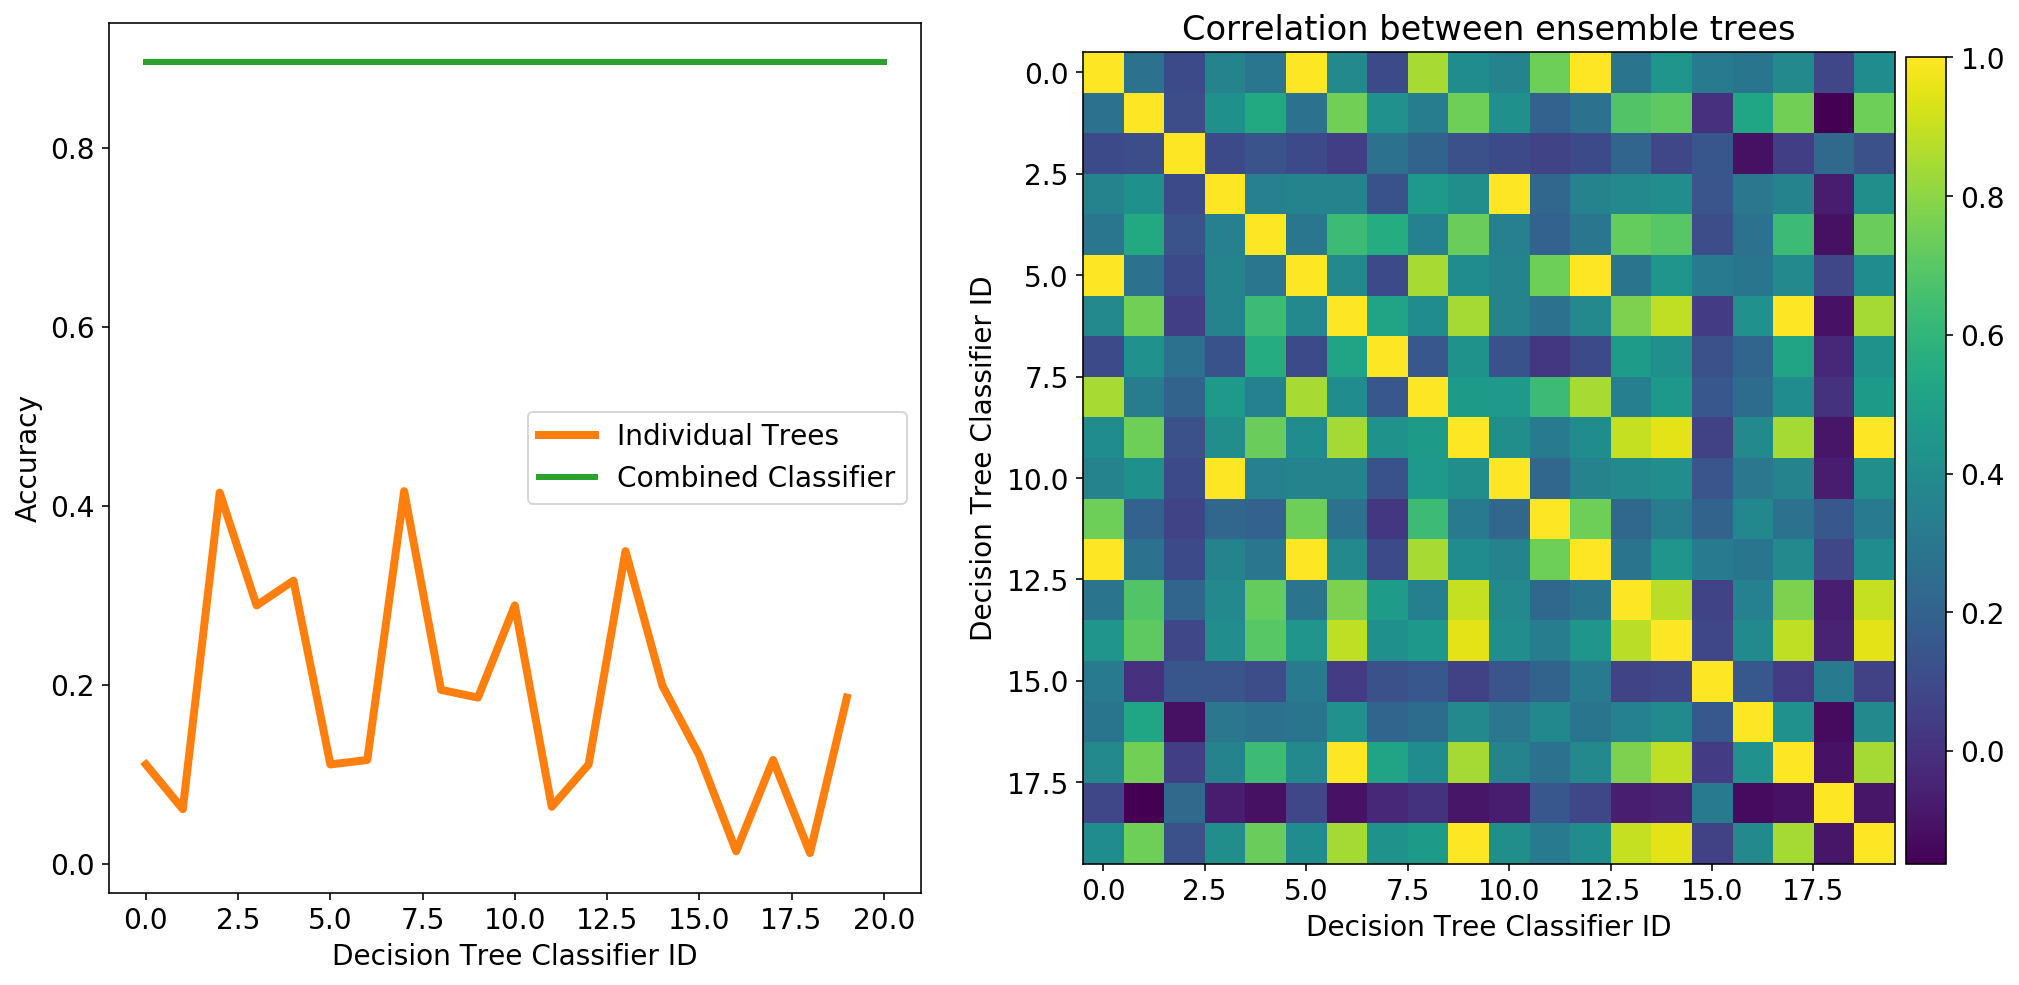

In [5]:
# results for a forest with different random trees
est_rand = generate_DTCs()
for est in est_rand :
    est[1].fit(X_train, y_train)
eclf = VotingClassifier(estimators=est_rand, voting='soft')
eclf.fit(X_train, y_train)

plot_test_results(estimators=est_rand, ensemble=eclf, X_test=X_test, y_test=y_test)


The average correlation between trees in the random forest is: 
0.9999999999999999


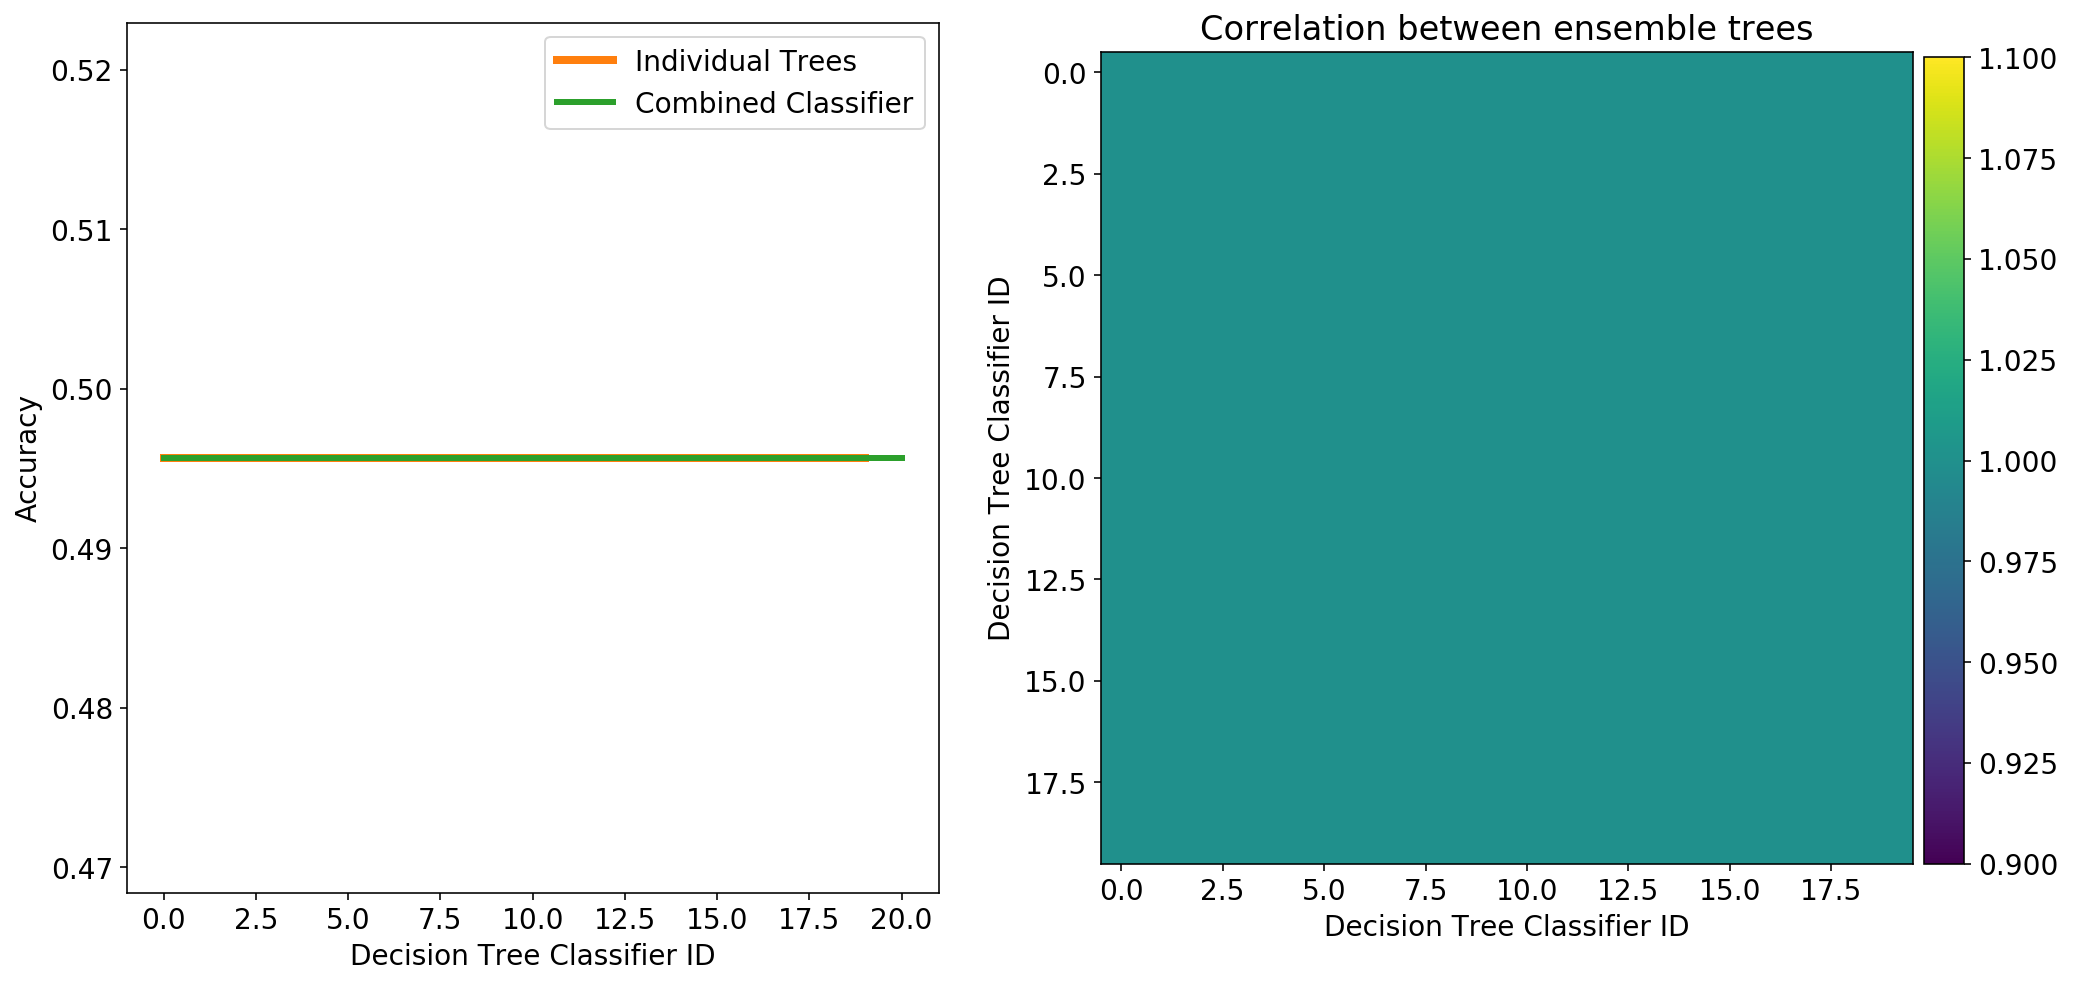

In [6]:
# results with the same tree used for the forest
est_same = generate_DTCs(rand=False)
for est in est_same :
    est[1].fit(X_train, y_train)

eclf = VotingClassifier(estimators=est_same, voting='soft')
eclf.fit(X_train, y_train)

plot_test_results(estimators=est_same, ensemble=eclf, X_test=X_test, y_test=y_test)

Clearly, when the same tree is used to generate the forest there is no advantage at the end

### Classifier Tests on Banking Data
Banking data is loaded with a function in utils.py
There is the possibility to chose between MultiLabelBinarizer encoding and LabelEncoder
The Binary labeling might be prefere in cases where it is important that the weight of the individual label values are kept equal. With LabelEncodin each value of a feature is mapped to a number and it might result in artificial advantage of a single value. However, if the individual values are treated as separate classes and then it does not matter which labeling cheme is used

Fraction of data entries from the full dataset resulting in positive outcome
0.11265417111780131
The average correlation between trees in the random forest is: 
0.2579613175417099


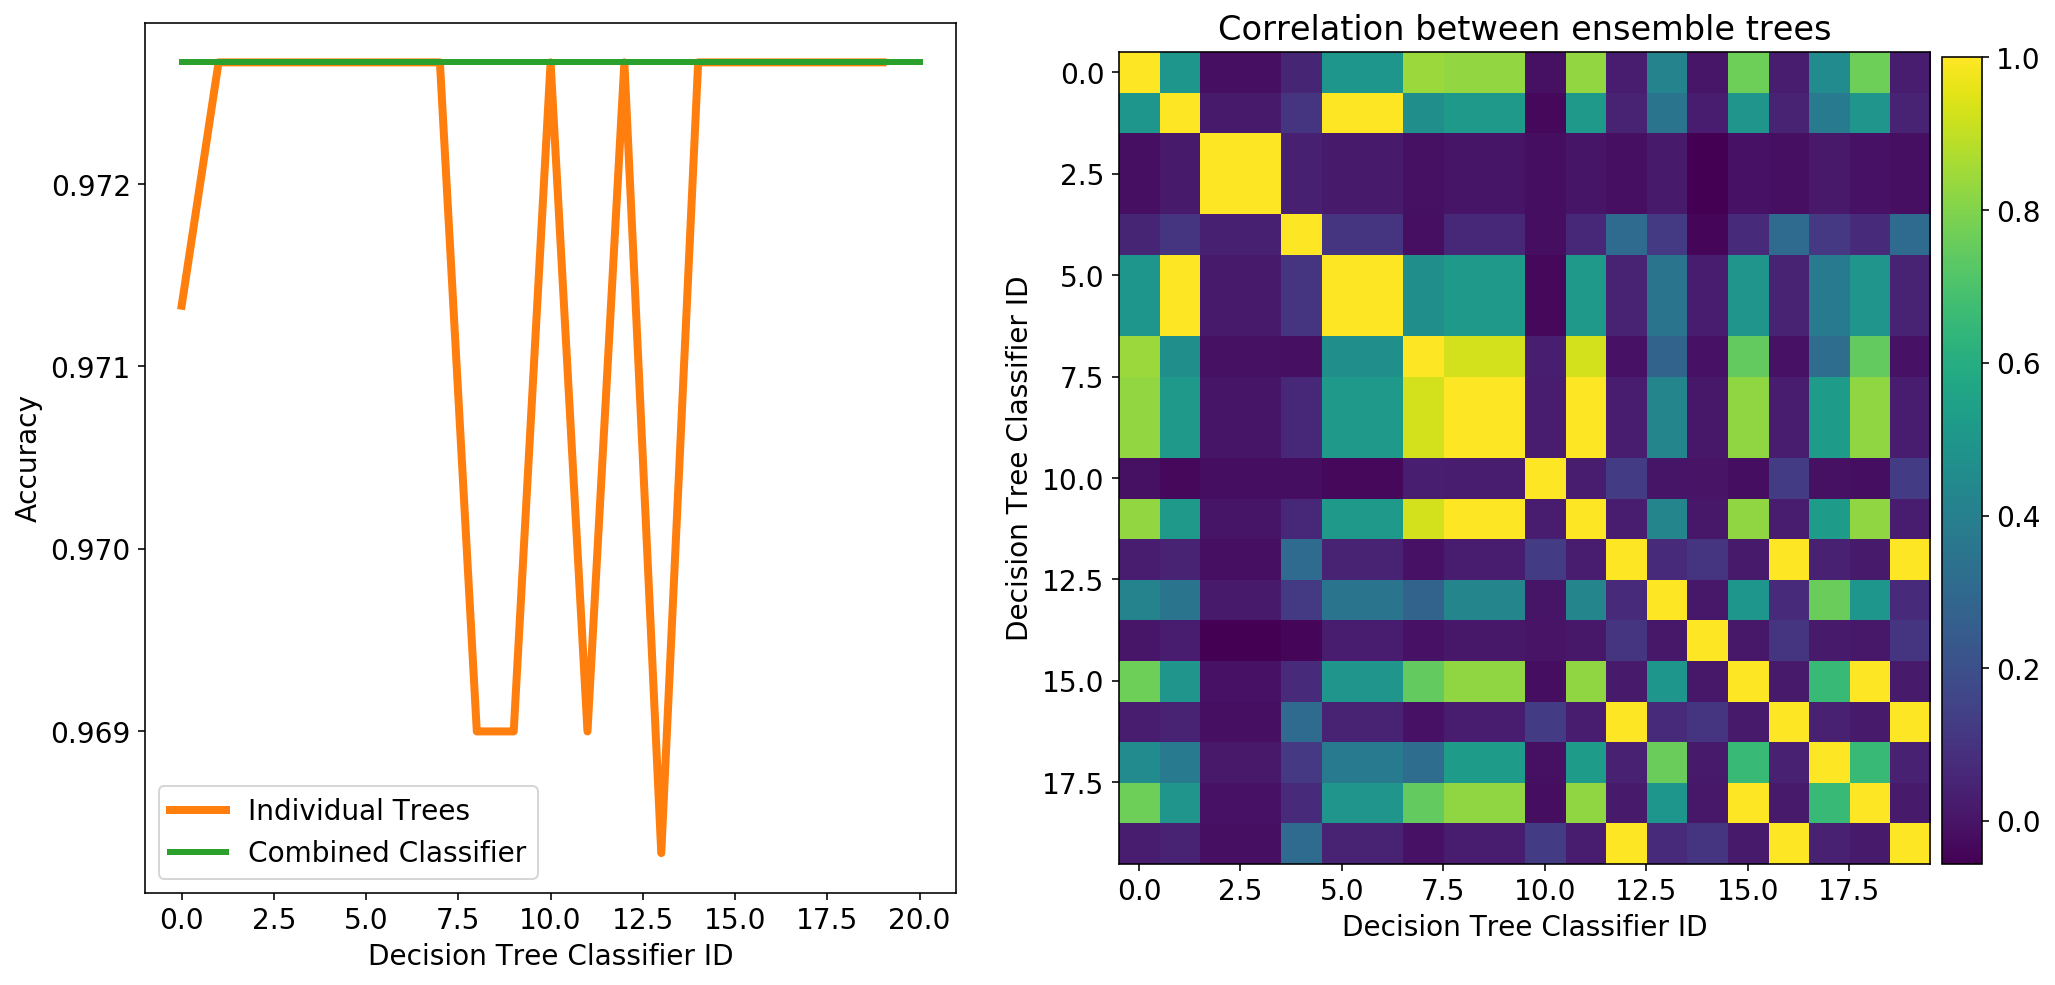

In [7]:
X, y = load_banking(bin_label=False)
split = 0.7
X_train, X_test, y_train, y_test = train_test_split(X[:10000], y[:10000], train_size=split, 
                                                    random_state=rand_state, )
n_y1 = 0
for e in y:
    if e == 1 :
        n_y1 += 1
print("Fraction of data entries from the full dataset resulting in positive outcome:")
print(n_y1/len(y))   
est_rand = generate_DTCs(max_depth=5, n_features=5, n_trees=20)
for est in est_rand :
    est[1].fit(X_train, y_train)

eclf = VotingClassifier(estimators=est_rand, voting='soft')
eclf.fit(X_train, y_train)

plot_test_results(estimators=est_rand, ensemble=eclf, X_test=X_test, y_test=y_test)

With only 10% of the target outcomes being different the expected accuracy of a classifier is in the order of 90% with a few percent deviation depending on the combination of random trees. Hence, in order to study the performance of a given classifier a reduced dataset will be created such that the possible outcomes are present in equal number of cases

In [34]:
X, y = load_reduced_banking(bin_label=False, n_y_ratio=1.)
split = 0.7
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split)
n_y1 = 0
for e in y:
    if e == 1 :
        n_y1 += 1
print("Fraction of data entries from the full dataset resulting in positive outcome")
print(n_y1/len(y)) 

Fraction of data entries from the full dataset resulting in positive outcome
0.5118587975730833


The average correlation between trees in the random forest is: 
0.5845352044915108


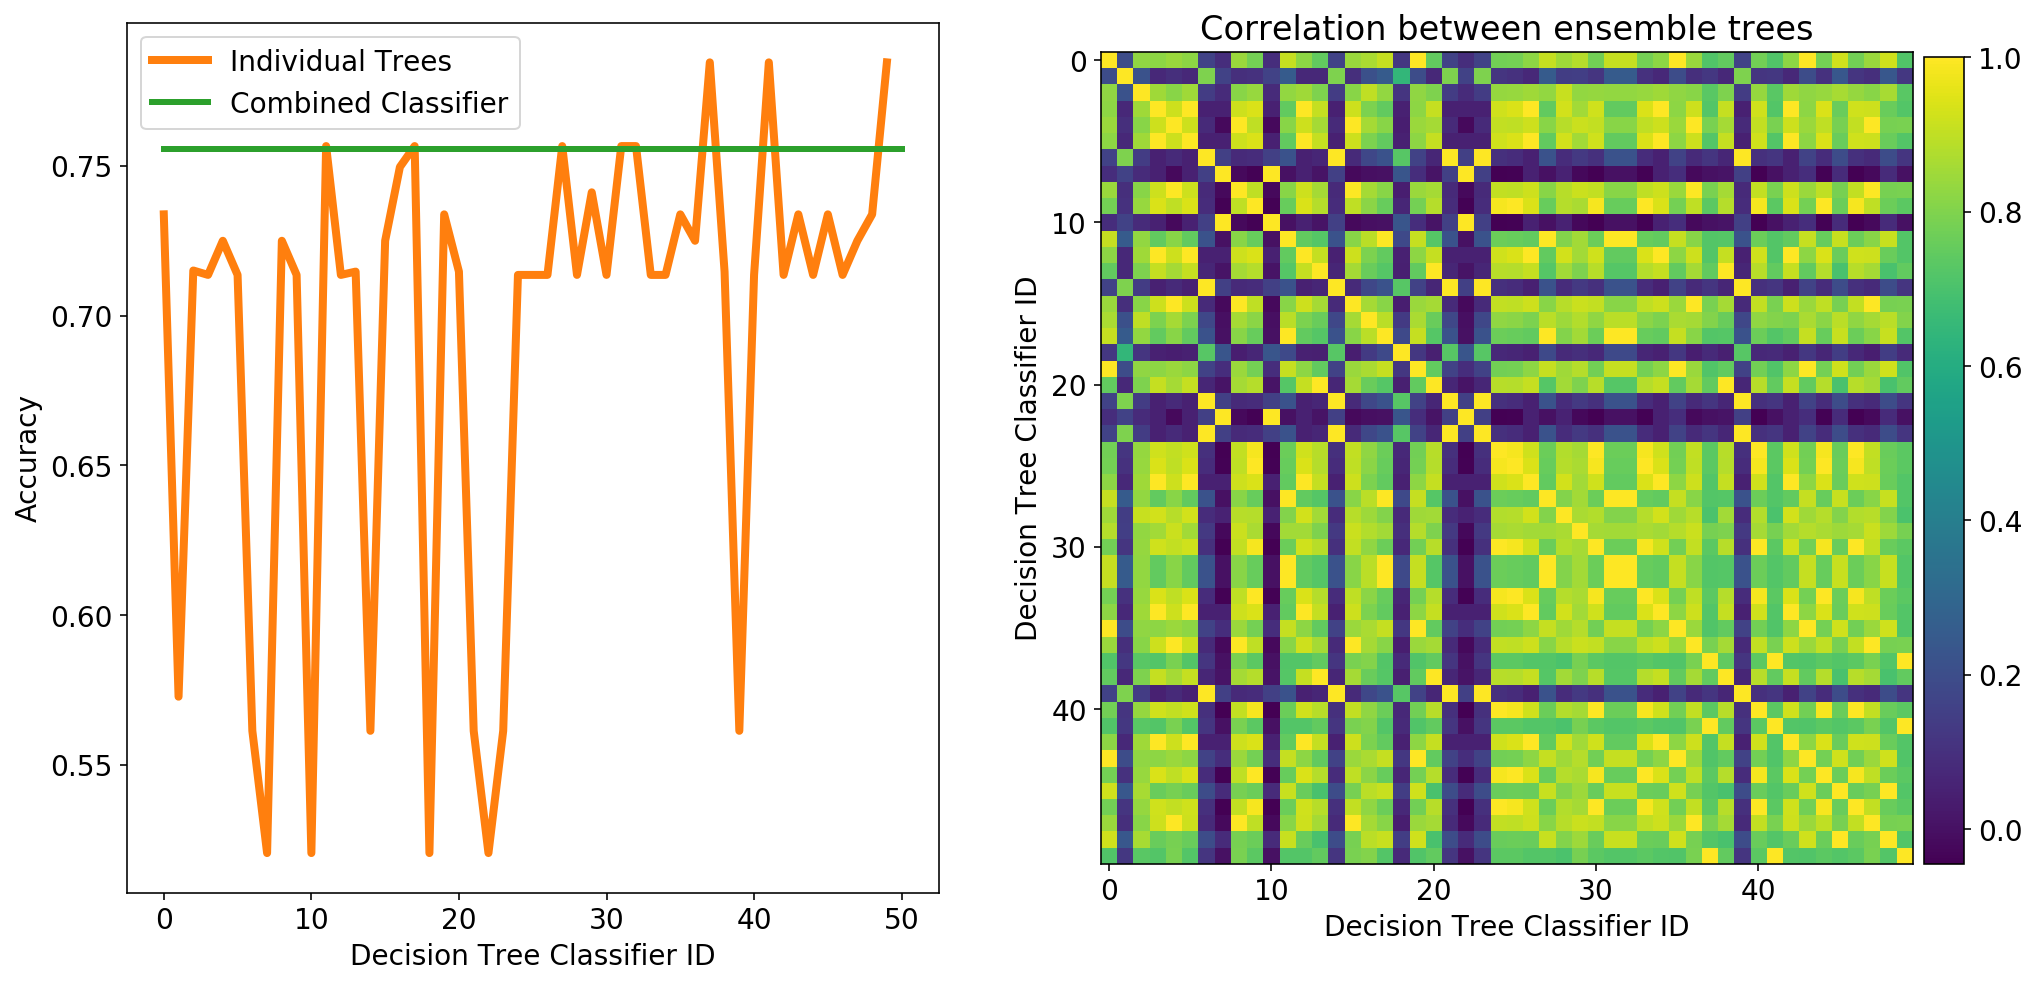

In [37]:
est_rand = generate_DTCs(max_depth=5, n_features=5, n_trees=50)
for est in est_rand :
    est[1].fit(X_train, y_train)

eclf = VotingClassifier(estimators=est_rand, voting='soft')
eclf.fit(X_train, y_train)

plot_test_results(estimators=est_rand, ensemble=eclf, X_test=X_test, y_test=y_test)

The average correlation between trees in the random forest is: 
1.0


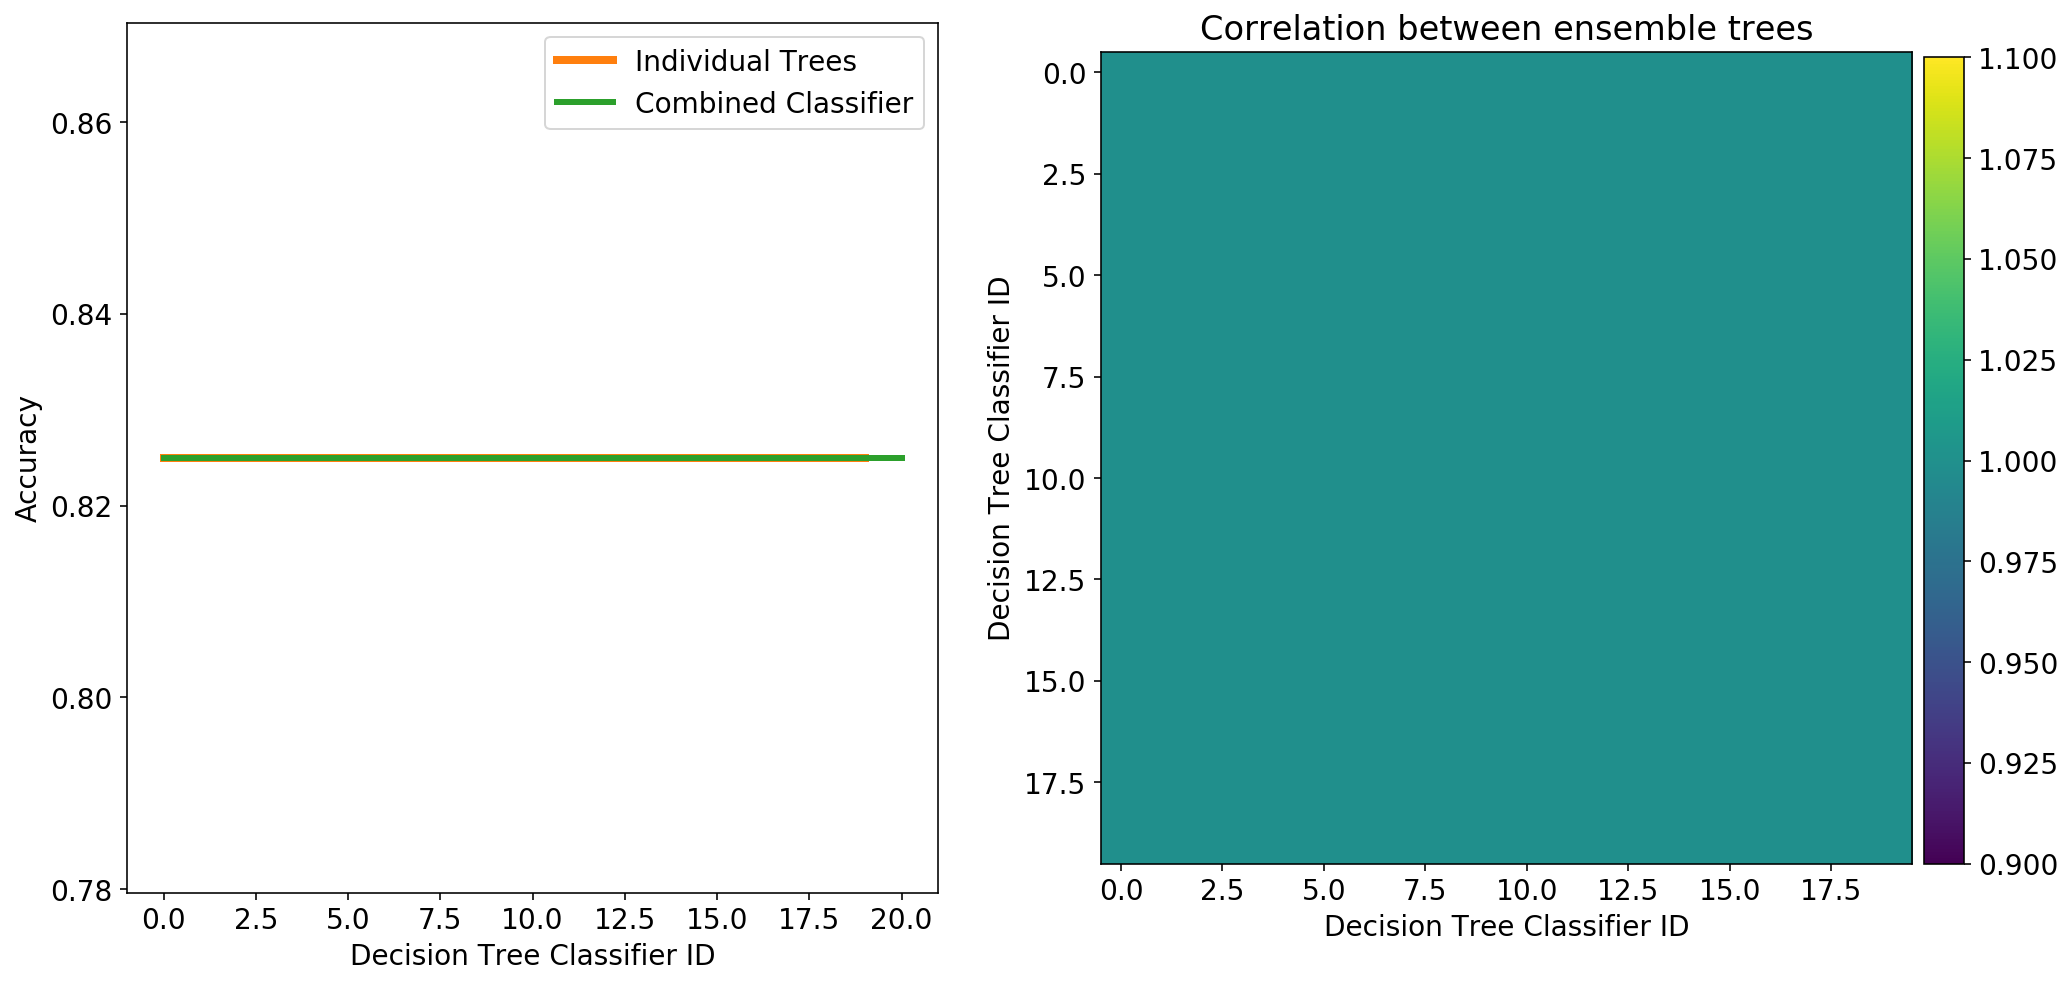

In [36]:
est_rand = generate_DTCs(max_depth=7, n_features=7, n_trees=20, rand=False)
for est in est_rand :
    est[1].fit(X_train, y_train)

eclf = VotingClassifier(estimators=est_rand, voting='soft')
eclf.fit(X_train, y_train)

plot_test_results(estimators=est_rand, ensemble=eclf, X_test=X_test, y_test=y_test)

With an equal split of the target class outcomes the prediction accuracy of the proposed random forest classifier seems to be significatly different from blind slelction of the outcome (the expected success rate for blind selection being 50% and the observed above 70%). However, contrary to the blobs data the "wisdom" of the many is not much different from the combined result which approximates the "average" of the many.

# Question 2

In [149]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier()

param_grid={
            'max_features': [2, 5, 10, 20],
            'max_depth' : range(1, 10),
            'n_estimators' : [5, 10, 20, 50, 100, 200],
            'n_jobs' : [4]
            }

X, y = load_banking(bin_label=False)
split = 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split)

# gs = GridSearchCV(rfc, param_grid=param_grid)
# gs.fit(X_train, y_train)
# print('Best parameter values from GS:', gs.best_params_)
# print('Best score from GS:', gs.best_score_)


In [151]:
rfc.set_params(max_depth=6, max_features=20, n_estimators=200, n_jobs=4)
rfc.fit(X_train, y_train)
score = rfc.score(X_test, y_test)
print('Test score with best parameters:', score)

Test score with best parameters: 0.9141011945226765


In [229]:
X, y = load_reduced_banking(bin_label=False)
split = 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split)

param_grid={
            'max_features': [2, 5, 10, 20],
            'max_depth' : range(1, 10),
            'n_estimators' : [5, 10, 20, 50, 100, 200],
            'n_jobs' : [4]
            }

# gs = GridSearchCV(rfc, param_grid=param_grid)
# gs.fit(X_train, y_train)
# print('Best parameter values from GS:', gs.best_params_)
# print('Best score from GS:', gs.best_score_)
rfc.set_params(max_depth=6, max_features=20, n_estimators=150, n_jobs=4)
rfc.fit(X_train, y_train)
score = rfc.score(X_test, y_test)
print('Test score with best parameters:', score)

Test score with best parameters: 0.8703145196036192


The results with the scikit learn RandomForestClassifier are consistent with the ones obtained with the generated random forest classifier

# Question 3

In [189]:
from sklearn.externals.joblib import load
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

d = load('datasets/cal_housing_py3.pkz')
X, y = d[:,1:], np.round(d[:,0]/10000)
X[:, 2] /= X[:, 5]
X[:, 3] /= X[:, 5]
X[:, 5] = X[:, 4] / X[:, 5]

feature_names = ["MedInc", "HouseAge", "AveRooms", "AveBedrms",
                    "Population", "AveOccup", "Latitude", "Longitude"]

split = 0.7
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split)

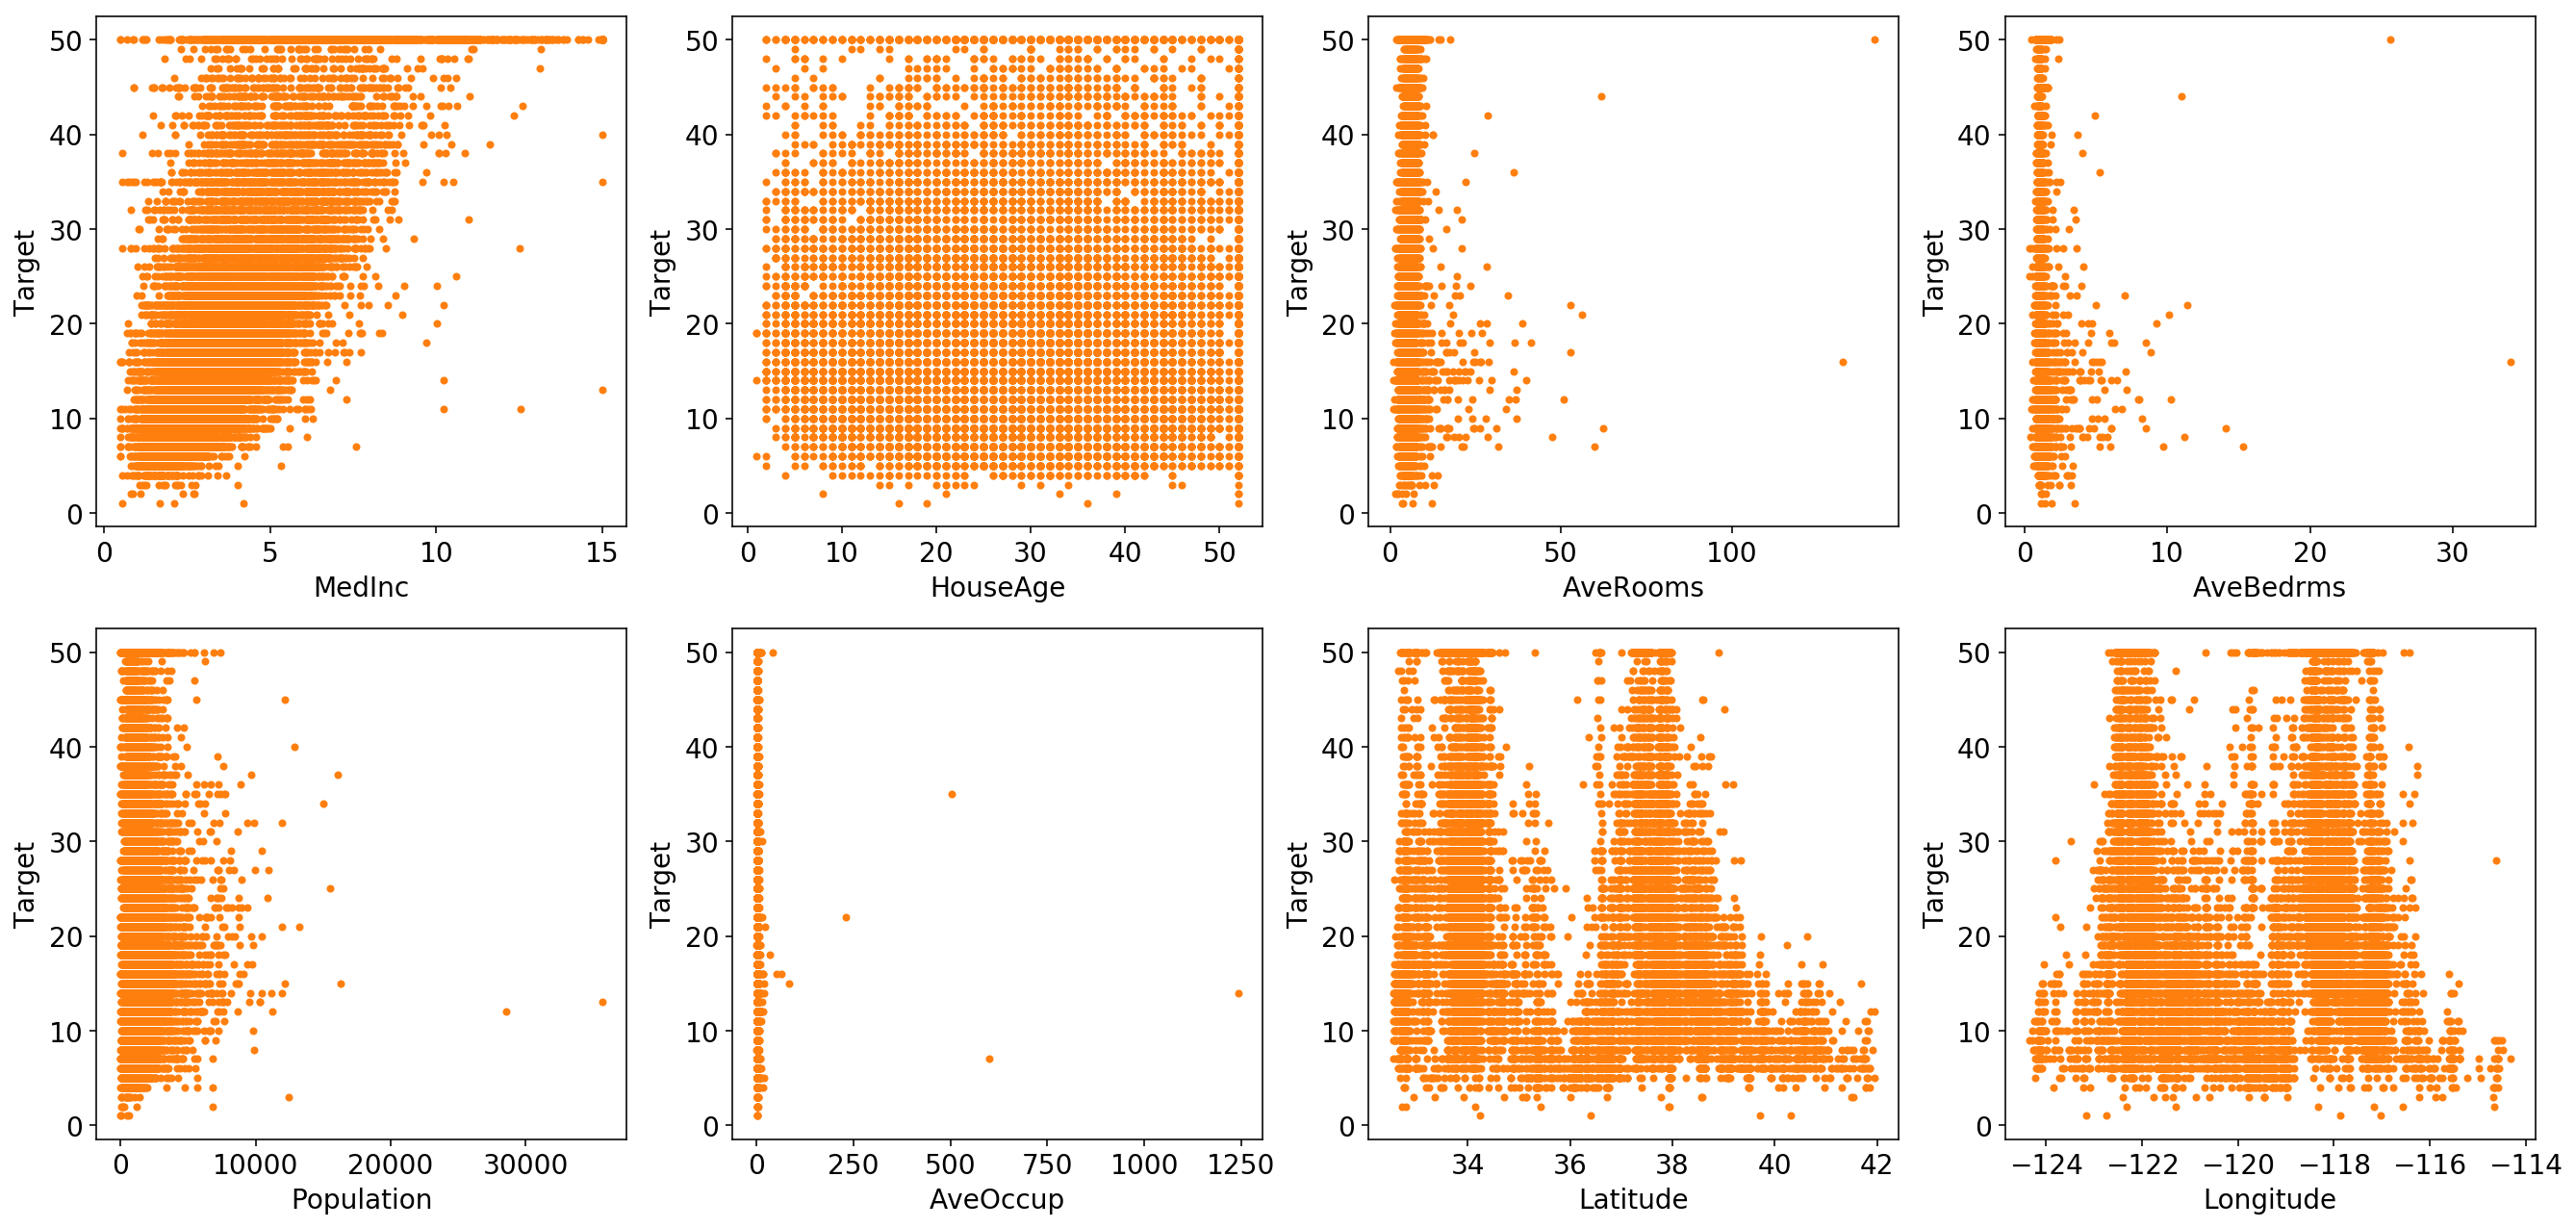

In [190]:
fig, axs = plt.subplots(figsize=(16, 12), ncols=4, nrows=2)
    
i=0    
for sub in axs:
    for a in sub:
        a.scatter(X[:, i], y, marker=".", c='tab:orange')
        a.set_xlabel(feature_names[i])
        a.set_ylabel('Target')
        i += 1
plt.subplots_adjust(top=0.8, left = -0.2) 
plt.show()

Looking at the plots, I would expect the MedInc to have relatively high importance, followed by Latitude, Longtidute and Population in some order. The rest don't demonstrate high correlation with the target, but they might be correlated with other features.

For the next step each fo the three classifiers will be evaluated in grid search with varying number of estimators and then the best parameter values will be used for the analysis.

The GradientBoostingClassifier requires categorized entries for target, hence the values of y were chosen in a range from 0 to 50 by rounding the price of the house.

In [195]:
param_grid = {'n_estimators': range(50, 100, 10),
              'max_features' : range(1, 8),
              'max_depth' : range(1,5),
              'n_jobs' : [4]}
rfc = RandomForestClassifier()
gs = GridSearchCV(rfc, param_grid).fit(X_train, y_train)
print ('Best parameters and score for RFC: ', gs.best_params_, gs.best_score_)

etc = ExtraTreesClassifier()
gs = GridSearchCV(etc, param_grid).fit(X_train, y_train)
print ('Best parameters and score for ETC: ', gs.best_params_, gs.best_score_)

Best parameters and score for RFC:  {'max_depth': 4, 'max_features': 3, 'n_estimators': 80, 'n_jobs': 4} 0.1323458157402921
Best parameters and score for ETC:  {'max_depth': 4, 'max_features': 6, 'n_estimators': 50, 'n_jobs': 4} 0.12106319651138644


Best parameters and score for RFC:  {'max_depth': 4, 'max_features': 3, 'n_estimators': 80, 'n_jobs': 4}

0.132


Best parameters and score for ETC:  {'max_depth': 4, 'max_features': 6, 'n_estimators': 50, 'n_jobs': 4}

0.121

In [200]:
param_grid = {'n_estimators':[1, 2, 3],
              'max_features': range(1,4),
              'learning_rate' : np.linspace(0.1, 1, 3)
             }

gbc = GradientBoostingClassifier()
gs = GridSearchCV(gbc, param_grid).fit(X_train, y_train)
print ('Best parameters and score for GBR: ', gs.best_params_, gs.best_score_)

Best parameters and score for GBR:  {'learning_rate': 0.1, 'max_features': 3, 'n_estimators': 3} 0.12466255970097598


Best parameters and score for GBR:  {'learning_rate': 0.1, 'max_features': 3, 'n_estimators': 3}

0.12466255970097598

In [222]:
rfc.set_params(max_depth=4, max_features=3, n_estimators=80, n_jobs=4)
etc.set_params(max_depth=4, max_features=6, n_estimators=50, n_jobs=4)
gbc.set_params(learning_rate=0.1, max_features=3, n_estimators=3)

cls = [('RFC', rfc), ('ETC', etc), ('GBC',gbc)]

features = []

print('Score from the three classifiers obtained at the best parameter settings for each')
for cl in cls :
    cl[1].fit(X_train, y_train)
    print(cl[0], cl[1].score(X_test, y_test))
    features.append((cl[0], (feature_names, cl[1].feature_importances_)))

Score from the three classifiers obtained at the best parameter settings for each
RFC 0.12772485063781688
ETC 0.115937348619409
GBC 0.1349911190053286


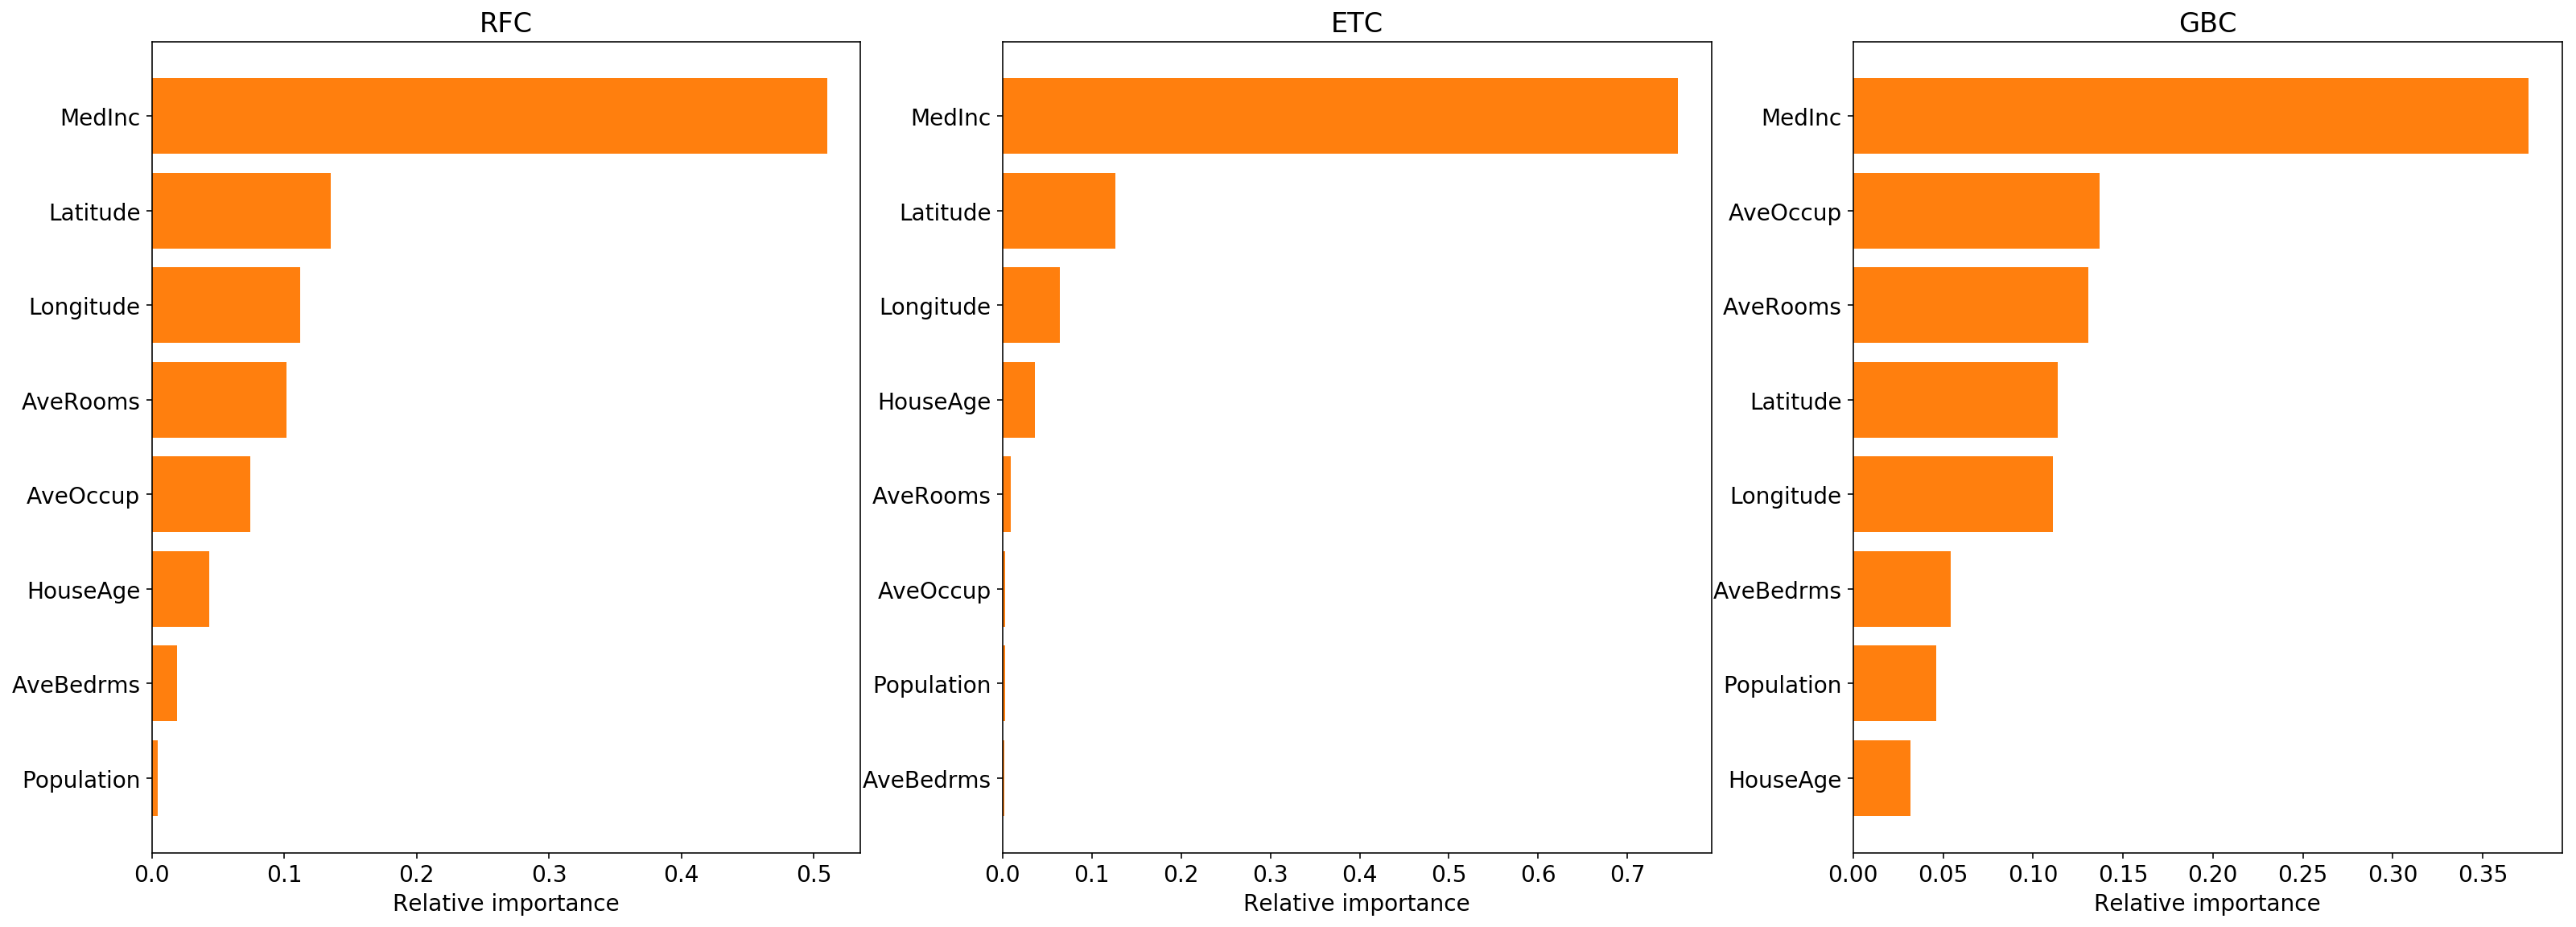

In [227]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=3)
 
a_i=0
for f in features :
    sorted_idx = np.argsort(f[1][1:2])
    pos = np.arange(sorted_idx.shape[1]) + .5

    val = np.array(f[1][1:2][0][sorted_idx][0])
    label = []
    for i in sorted_idx[0] :
        label.append(f[1][:1][0][i])
    axs[a_i].barh(pos, val , align='center', color='tab:orange')
    axs[a_i].set_yticks(pos)
    axs[a_i].set_yticklabels(label)
    axs[a_i].set_xlabel("Relative importance")
    axs[a_i].set_title(f[0])
    a_i += 1
    
plt.subplots_adjust(top=1, left = -0.4)    
plt.show()

As expected the MedInc is the most important feature. The accuracy in predicting the outcome, however, remains very low: in the order of 10%